In [586]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al
from meep.materials import Al2O3 

In [587]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 100             # 추출할 주파수 개수
design_region_resolution = 50

In [588]:
tal = 1
talq3 = 0.5
tsio2 = 2

tair_near = 3.5
tair_far = 6

tpml = 0.5

tPDL = 1

design_region_width = 6       # OLED의 가로/세로 길이
design_region_height = 1
pdl_height = tal+talq3+design_region_height+tsio2

al = Al
pdl = Al2O3

alq3 = mp.Medium(index = 1.68)
sio2 = mp.Medium(index = 2.1)
SiN = mp.Medium(index = 1.8)
air = mp.Medium(index = 1)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

boundary_layers = [mp.PML(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]



In [589]:
Sy = tal+talq3+design_region_height+tsio2+tair_near+tpml
Sx = tpml+tPDL + design_region_width + tPDL + tpml  # x 방향 전체 크기 (design_region_width=6)

# --- 3. y축 아래쪽(bottom) 좌표 계산 ---
y_bottom = -Sy/2  # 전체 셀의 맨 바닥 y값

# --- 4. 층별 센터 y 좌표 계산 (아래에서 위로) ---
# 1) Al
center_y_al = y_bottom + tal / 2

# 2) Alq3
center_y_alq3 = y_bottom + tal + talq3 / 2

# 3) Design Region (SiN↔SiO2 중간)
center_y_design = y_bottom + tal + talq3 + design_region_height / 2

# 4) SiO2
center_y_sio2 = y_bottom + tal + talq3 + design_region_height + tsio2 / 2

# 5) Air (맨 위)
center_y_air = y_bottom + tal + talq3 + design_region_height + tsio2 + tair_near / 2

# --- 5. Al₂O₃(측면) 블록 높이 및 y 중심 좌표 ---
pdl_height = talq3 + design_region_height + tsio2
center_y_pdl = y_bottom + pdl_height / 2

# --- 6. Al₂O₃(측면) 블록 x 중심 좌표 계산 ---
x_left_pdl  = - (design_region_width/2 + tPDL/2)
x_right_pdl = + (design_region_width/2 + tPDL/2)

tpml          = 0.5


cell_size = mp.Vector3(Sx, Sy)

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), sio2,SiN,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0,center_y_design,0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    # ───────────────────────────────────────────────
    # 1) Al 층 (맨 아래)
    mp.Block(
        material=al,
        size=mp.Vector3(mp.inf, tal, design_region_width),
        center=mp.Vector3(0, center_y_al, 0)
    ),

    # 2) Alq3 층
    mp.Block(
        material=alq3,
        size=mp.Vector3(design_region_width, talq3, design_region_width),
        center=mp.Vector3(0, center_y_alq3, 0)
    ),

    # 3) Design Region (SiN ↔ SiO₂)
    mp.Block(
        material=design_variables,                  # MaterialGrid로 정의된 design region
        size=mp.Vector3(design_region_width, design_region_height, design_region_width),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    # 4) SiO₂ 층
    mp.Block(
        material=sio2,
        size=mp.Vector3(design_region_width, tsio2, design_region_width),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),

    # ───────────────────────────────────────────────
    # 6) Al₂O₃ 측면 (왼쪽)
    mp.Block(
        material=pdl,
        size=mp.Vector3(2, pdl_height, design_region_width),
        center=mp.Vector3(
            - (design_region_width/2 + tPDL/2),
            -1.5,
            0
        )
    ),

    # Al₂O₃: OLED 구조 우측
    mp.Block(
        material=pdl,
        size=mp.Vector3(2, pdl_height, design_region_width),
        center=mp.Vector3(
            + (design_region_width/2 + tPDL/2),
            -1.5,
            0
        )
    ),
]

In [590]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 5

for i in range(src_num):
    # x: 디자인 영역 너비를 (i+1)/(src_num+1) 비율로 분할
    x_i = -design_region_width/2 + design_region_width * ((i+1) / (src_num+1))
    
    sources.append(
        mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                x_i,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )
        )
    )

# --- 2. Simulation 객체 생성: 각 Source당 하나씩 시뮬레이션 인스턴스 생성 ---
sim = []
for i in range(src_num):
    sim.append(
        mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=boundary_layers,
            geometry=geometry,
            sources=[sources[i]],
            # default_material=air,
            extra_materials=[al, pdl],  # 필요에 따라 추가 물질
        )
    )

In [591]:
flux_air = sim[0].add_flux(fcen, 0, 1,
    mp.FluxRegion(
        center = mp.Vector3(-4,2),
        size = mp.Vector3(0,tair_near)
    ),
    mp.FluxRegion(
        center = mp.Vector3(4,2),
        size = mp.Vector3(0,tair_near)
    ),
    mp.FluxRegion(
        center = mp.Vector3(0,3.75),
        size = mp.Vector3(8,0)
    ),
)

<Axes: xlabel='X', ylabel='Y'>

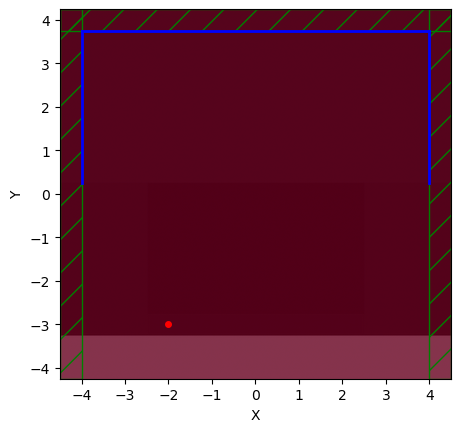

In [593]:
sim[0].plot2D(fields = mp.Ez)

In [594]:
tol = 1e-8

src_center = mp.Vector3(
                0,
                center_y_alq3,  # Alq3 층의 중간 높이
                0
            )

sim[0].run(
    mp.dft_ldos(fcen,0,1),
    until_after_sources=mp.stop_when_fields_decayed(20, mp.Ez, src_center, tol),

)

KeyboardInterrupt: 

In [ ]:
out_flux = mp.get_fluxes(flux_air)
out_flux
dA = 1 / (resolution**2)

total_flux = -np.real(sim[0].ldos_Fdata[0] * np.conj(sim[0].ldos_Jdata[0])) *dA
total_flux

ext_eff = out_flux / total_flux
print(" Out flux :", out_flux,"\n", "Total flux :", total_flux,"\n", "EQE(%) :", ext_eff*100)

 Out flux : [0.29380314922351963] 
 Total flux : 0.8820451166948555 
 EQE(%) : [33.30931079]
